In [ ]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 13.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdMolDescriptors import GetMACCSKeysFingerprint
from rdkit.Chem.Crippen import MolLogP
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv(r"/content/dataset_v1.csv", usecols = ['SMILES'])
#не тянет весь датасет
df = df.sample(n = 100, random_state = 9)
print(df.head())
#list_of_smiles = df['SMILES']


                                           SMILES
49574             O=c1ccc2cc(O)c(OCc3ccccc3)cc2o1
1530849           CC1Cc2nc(N)nn2CC1c1ccc(O)c(F)c1
1007434  CC(CN1CCOCC1)NC(=O)Cn1cc(C(F)(F)F)ccc1=O
1863635      O=S(=O)(NCc1cc2ccccn2n1)c1c(F)cccc1F
771230      Cc1ccc(OCC(=O)OCc2cccc(C(N)=O)c2)cc1C


In [ ]:
def mols(smiles_or_mol):
    if isinstance(smiles_or_mol, str):
        if len(smiles_or_mol) == 0:
            return None
        mol = Chem.MolFromSmiles(smiles_or_mol)

        if mol is None:
            return None
        try:
            Chem.SanitizeMol(mol) # Исправляет неккоректную структуру молекулы
        except ValueError:
            return None
        fingerprint = GetMACCSKeysFingerprint(mol)
        logp = MolLogP(mol)
        return fingerprint, logp
    return smiles_or_mol

In [ ]:
# Создаю списка Mol объектов из SMILES и получаю MACCS ключей и значений logP для каждой молекулы
fingers = []
logp_list = []
for smiles in df['SMILES']:
    fingerprint, logp = mols(smiles)
    if fingerprint is not None and logp is not None:
        fingers.append(fingerprint)
        logp_list.append(logp)
print(fingers[:5])
print(logp_list[:5])

[<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f0a2d2bf6f0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f0a2d2bf760>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f0a2d2bf7d0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f0a2d2bf840>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f0a2d2bf8b0>]
[3.0776000000000012, 1.6809999999999998, 0.7039999999999997, 2.091, 2.524540000000001]


In [ ]:
# Преобразую данных в массивы numpy
X = np.array(fingers)
y = np.array(logp_list)
X = np.hstack((np.ones((X.shape[0], 1)), X))
print(y.shape)

(100,)


In [ ]:
# Веса
weights = np.random.rand(X.shape[1], 100)
#weights = weights.T
# Гиперпараметры
learning_rate = 0.001
max_iter = 100

In [ ]:
def line(x, w, b):
  y_predict = np.dot(x, w) + b
  return y_predict

def loss(y_true, y_predict):
  l = 0

  for i in range(len(y_true)):
    l += (y_true[i] - y_predict[i])**2
  return l / len(y_true)


In [ ]:
y_predict = line(X, weights, 1)
#y_predict = y_predict.reshape(-1)
loss_value = loss(y, y_predict)
print(y.shape)
print(y_predict.shape)
print(weights.shape)


(100,)
(100, 100)
(1025, 100)


In [ ]:
# def derivative_w_numeric(w, b, delta=0.01):
#   y_predict_1 = line(X, w, b)
#   y_predict_2 = line(X, w + delta, b)
#   loss_1 = loss(y, y_predict_1)
#   loss_2  = loss(y, y_predict_2)
#   return (loss_2 - loss_1) / delta

# def derivative_b_numeric(w, b, delta=0.001):
#   y_predict_1 = line(X, w, b)
#   y_predict_2 = line(X, w, b + delta)
#   loss_1 = loss(y, y_predict_1)
#   loss_2  = loss(y, y_predict_2)
#   return (loss_2 - loss_1) / delta


In [ ]:
def derivative_w_analytic(w, b):
    dldw = 0
    dldw = 2 * np.dot((np.dot(X, w) + b - y).T, X)
    return dldw / len(y)

def derivative_b_analytic(w, b):
    dldb = 0
    dldb += 2 * (np.dot(X, w) + b - y)
    return dldb / len(y)

In [ ]:
# print(derivative_w_numeric(0.6, 2, delta=0.0001))
# print(derivative_w_numeric(0.23, 2, delta=0.0001))

print(derivative_w_analytic(weights, 1))
print(derivative_b_analytic(weights, 1))


[[37.5113916   0.          8.27888153 ...  0.81081103  0.
   1.13688622]
 [39.93408585  0.          8.63786431 ...  0.75626671  0.
   1.25699655]
 [45.49011637  0.         10.01553529 ...  0.92447713  0.
   1.30232863]
 ...
 [41.94772212  0.          9.23588079 ...  0.88729285  0.
   1.28809634]
 [41.75110395  0.          8.95785496 ...  0.80231169  0.
   1.31754942]
 [38.38528467  0.          8.7860535  ...  0.76803555  0.
   1.21038625]]
[[0.32460318 0.35530434 0.42141737 ... 0.33441979 0.36709741 0.25451616]
 [0.37739453 0.39283615 0.48136045 ... 0.41462626 0.40392949 0.3799524 ]
 [0.37999076 0.43748914 0.44545064 ... 0.43973997 0.45163877 0.44010783]
 ...
 [0.40060515 0.37082955 0.43872392 ... 0.39135231 0.38806158 0.35761835]
 [0.37012743 0.42825194 0.50110009 ... 0.43858601 0.48827965 0.35811637]
 [0.38792922 0.40570298 0.46981185 ... 0.42951027 0.45748435 0.32218473]]


In [ ]:
def get_grad(y_predicted, y):
    error = (y_predicted - y)
    gradient = 2*np.dot(error.T, X)/len(y)
    return gradient


def gd_algorithm(w_start, b_start, learning_rate=0.01, max_iter=100):
  w, b = w_start, b_start
  ll = []
  for iter in range(max_iter):
    y_predicted = line(X, w, b)
    l = loss(y, y_predicted)
    ll.append(l)

    w = w - learning_rate * derivative_w_analytic(w, b).T
    b = b - learning_rate * derivative_b_analytic(w, b)
  return w, b, ll



In [ ]:
w, b, ll = gd_algorithm(weights, 1, learning_rate=0.0001, max_iter=100)
print("Оптимальные веса:", w)
print("Оптимальные байесы:", b)

Оптимальные веса: [[-0.19912183 -0.24777812  0.34001946 ... -0.32695141 -0.01995452
  -0.24300968]
 [ 0.94487594  0.91563189  0.482673   ...  0.19324157  0.80819773
   0.05181552]
 [ 0.5003292  -0.02194591  0.16155858 ...  0.84019407  0.29732473
   0.82033119]
 ...
 [ 0.70598248  0.19444244  0.55913296 ...  0.43109543  0.37128669
   0.75830959]
 [ 0.88078819  0.57875236  0.65270093 ...  0.10836983  0.12800734
   0.99927284]
 [ 0.60817755  0.22950924  0.1529905  ...  0.67790332  0.63254567
   0.12374816]]
Оптимальные байесы: [[0.99710868 0.99682549 0.9962201  ... 0.99705124 0.99672555 0.99781598]
 [0.99659893 0.99646881 0.99563899 ... 0.99627119 0.99637589 0.99658159]
 [0.99664896 0.99610307 0.99608934 ... 0.99610566 0.99598482 0.99606197]
 ...
 [0.99642733 0.99674904 0.99613456 ... 0.99656743 0.99659744 0.99686342]
 [0.99673723 0.9961855  0.9955247  ... 0.99610647 0.99560961 0.99686953]
 [0.99657986 0.99643284 0.99586247 ... 0.99621999 0.99593762 0.99724856]]


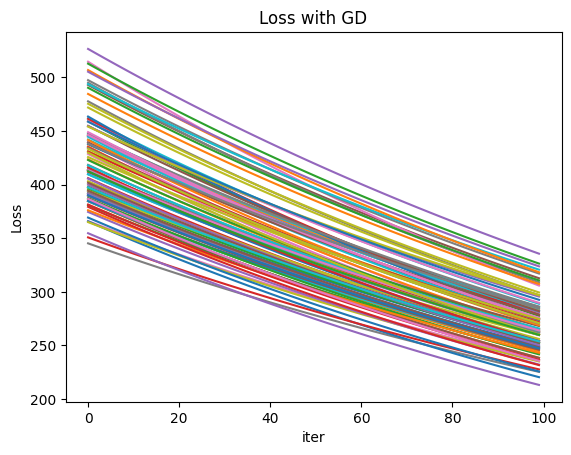

In [ ]:
import matplotlib.pyplot as plt

plt.plot(ll)
plt.xlabel('iter')
plt.ylabel('Loss')
plt.title('Loss with GD')
plt.show()